<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/main/recipes/medical_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

# Kili Tutorial: Reading and uploading dicom image data

In this tutorial, we will show you how to upload medical images to Kili Technology. We will use [pydicom](https://pydicom.github.io/pydicom/stable/), a Python package that reads medical data in Dicom format.

Data used in this tutorial comes from the [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data) hosted on Kaggle in 2018.

First of all, let us import the packages, and install pydicom in case you don't have it installed.

In [ ]:
!pip install pydicom matplotlib Pillow
!pip install wget
import os
import glob
from collections import defaultdict
import pickle
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches
from PIL import Image
import numpy as np
import pandas as pd
import wget

We'll upload the images, extract DICOM metadata, and generate jpeg images from the dicom images.
Then we'll upload your generated jpegs.

In [ ]:
# If you're running this code from the downloaded Kili repo, run this code:

# if 'recipes' in os.getcwd():
#     os.chdir('..')
# data_folder = "./recipes/datasets"

# Otherwise, run this code:

wget.download(
    "https://github.com/kili-technology/kili-python-sdk/blob/main/recipes/datasets/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm?raw=true"
)
wget.download(
    "https://github.com/kili-technology/kili-python-sdk/blob/main/recipes/datasets/0005d3cc-3c3f-40b9-93c3-46231c3eb813.dcm?raw=true"
)
wget.download(
    "https://github.com/kili-technology/kili-python-sdk/blob/main/recipes/conf/medical-labels.pkl?raw=true"
)

data_folder = "."


files = glob.glob(f"{data_folder}/*.dcm")
files

['./0005d3cc-3c3f-40b9-93c3-46231c3eb813.dcm',
 './0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm']

In [ ]:
def dcm2metadata(sample):
    metadata = {}
    for key in sample.keys():
        if key.group < 50:
            item = sample.get(key)
            if hasattr(item, "description") and hasattr(item, "value"):
                metadata[item.description()] = str(item.value)
    return metadata


processed_imgs = []
metadata_array = []
for file in files:
    fname = os.path.split(file)[-1].split(".")[0]
    sample = pydicom.dcmread(file)
    im = Image.fromarray(sample.pixel_array)
    fpath = os.path.join(data_folder, f"{fname}.jpeg")
    im.save(fpath)
    processed_imgs.append(fpath)
    metadata_array.append(dcm2metadata(sample))

Next, we just need to connect to Kili, create a project, and define the annotation interface. You can also refine the interface in the Kili app.

In [ ]:
!pip install  kili
from kili.client import Kili

# Don't forget to set your 'KILI_API_KEY' environment variable with your API Key: os.environ['KILI_API_KEY'] = "<YOUR_API_KEY>"
# If you use Kili on-premise, be sure to set your 'KILI_API_ENDPOINT' environment variable.

kili = Kili()

/Users/jonasm/kili-python-sdk/src/kili/authentication.py:44: UserWarning: Kili Python SDK version should match with Kili API version.
Please install version: "pip install kili==2.136.0"
  self.endpoint_kili_version = self.check_versions_match()


In [ ]:
# JSON interface
job_id = "JOB_0"
json_interface = {
    "jobs": {
        "CLASSIFICATION_JOB": {
            "mlTask": "CLASSIFICATION",
            "content": {
                "categories": {"YES": {"name": "Yes"}, "NO": {"name": "No"}},
                "input": "radio",
            },
            "required": 1,
            "isChild": False,
            "instruction": "Healthy ?",
        },
        "JOB_0": {
            "mlTask": "OBJECT_DETECTION",
            "content": {
                "categories": {
                    "BONE": {"name": "bone"},
                    "TISSUE": {"name": "tissue"},
                    "LUNG": {"name": "lung"},
                    "RIB": {"name": "rib"},
                },
                "input": "radio",
            },
            "required": True,
            "tools": ["semantic"],
            "instruction": "Segmentation",
        },
    }
}

We can now use the API to create our project and upload our images to the project.

In [ ]:
title = "Medical Imaging with Kili Technology"
description = "This is a test project"
input_type = "IMAGE"

project = kili.create_project(
    title=title, description=description, input_type=input_type, json_interface=json_interface
)
project_id = project["id"]

In [ ]:
content_array = [
    "https://drive.google.com/uc?id=18tEnN9lsKlp1tcd0WnfknZJq7d5v5Tod",
    "https://drive.google.com/uc?id=1jvt_LzZAvSr8wyRiwlibXdEszVvyQxjK",
]
external_id_array = ["01", "02"]
kili.append_many_to_dataset(
    project_id=project_id,
    content_array=content_array,
    external_id_array=external_id_array,
    json_metadata_array=metadata_array,
)

100%|██████████| 2/2 [00:00<00:00,  3.67it/s]


{'id': 'clj76nrzr00gf0j5x3jt98xa6'}

Done ! Your data is in the project. All that remains is to start labeling!
Below, we'll show you how you can visualize labels with Python, after downloading.
Here we do it with pre-saved labels but it could be done with your own labels, [see documentation](https://docs.kili-technology.com/docs/exporting-project-data).

In [ ]:
# If you're running this code from the downloaded Kili repo, run this code:

# with open('./recipes/conf/medical-labels.pkl', 'rb') as f:
#         labels = pickle.load(f)
# with open('./recipes/conf/medical-labels.pkl', 'wb') as f:
#     pickle.dump(labels, f)

# Otherwise, run this code:

with open("medical-labels.pkl", "rb") as f:
    labels = pickle.load(f)
with open("medical-labels.pkl", "wb") as f:
    pickle.dump(labels, f)

healthy = labels["CLASSIFICATION_JOB"]["categories"][0]["name"]
semantic = labels["JOB_0"]["annotations"]

We'll convert those labels to a Python format, and plot them using matplotlib : 

In [ ]:
points = pd.DataFrame(semantic[0]["boundingPoly"][0]["normalizedVertices"]).values


def transform2image(points, shape):
    newpoints = np.zeros(points.shape)
    newpoints[:, 0] = points[:, 0] * shape[0]
    newpoints[:, 1] = points[:, 1] * shape[1]
    return newpoints


category2points = defaultdict(list)
for annotation in semantic:
    category = annotation["categories"][0]["name"]
    points = pd.DataFrame(annotation["boundingPoly"][0]["normalizedVertices"]).values
    category2points[category].append(points)

fname = os.path.split(files[0])[-1].split(".")[0]
im = Image.open(f"{data_folder}/{fname}.jpeg")

Text(0.5, 1.0, 'Healthy : YES')

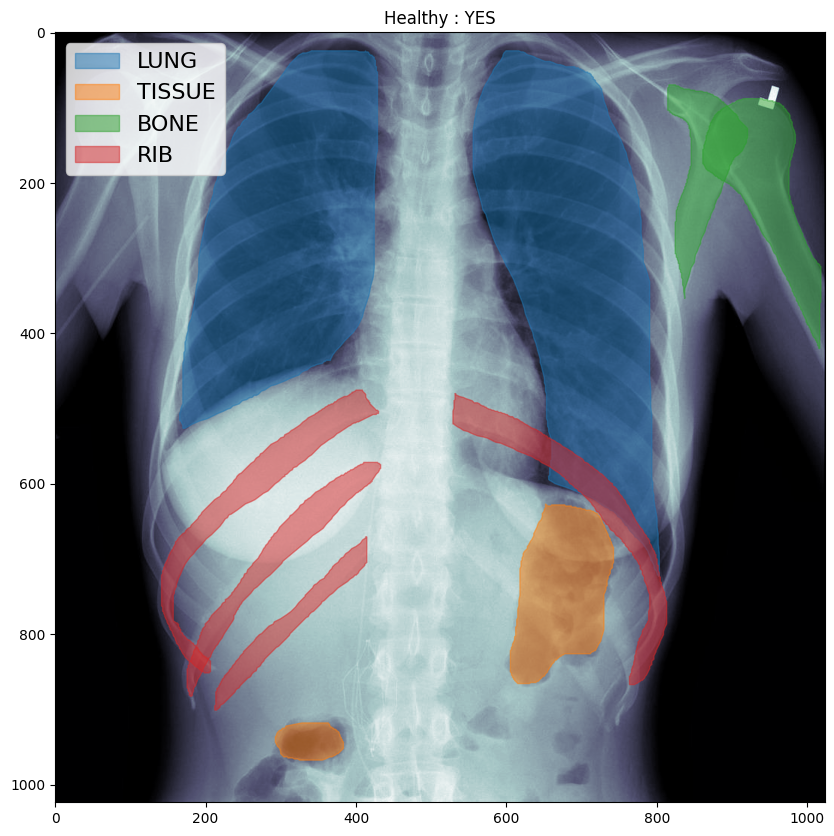

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im, cmap=plt.cm.bone)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, (category, shapes) in enumerate(category2points.items()):
    for j, shape in enumerate(shapes):
        if j == 0:
            poly = matplotlib.patches.Polygon(
                transform2image(shape, im.size), color=colors[i], alpha=0.5, label=category
            )
        else:
            poly = matplotlib.patches.Polygon(
                transform2image(shape, im.size), color=colors[i], alpha=0.5
            )
        ax.add_patch(poly)
ax.legend(fontsize=16)
ax.set_title(f"Healthy : {healthy}")

## Cleanup

In [ ]:
kili.delete_project(project_id)

'clj76nrzr00gf0j5x3jt98xa6'